### Digit Recognizer with Convolutional Neural Networks

1. Learn how to create a basic convolutional neural network with keras
2. Create custom convolution blocks
3. Use image augmentation
4. Train an efficientnetv2(ish) model using progressive learning

This tutorial comes from a series of deep learning blog posts, it is meant to be used after reading this post: https://www.notion.so/Convolutional-Neural-Networks-ebf47cf0add046a092a85ef616ad52af

# Preparing Data

### Import Modules

In [1]:
try:
    import visualkeras
except:
    !pip install visualkeras
    import visualkeras

import keras_cv
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/da/05/8912c901a3965ec7117d6cc33eaec3888c717611f72ce69d8be62a01d149/aggdraw-1.3.18-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.7 MB/s eta 0:00:00
Using TensorFlow backend


### Read Data
We can simply use pd.read_csv as we have done in the past. In a lot of datasets we will have image files instead of a csv, in those cases we can use a keras utility function which creates an image dataset from the files (explored later).

In [2]:
image_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
image_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Check for Class Imbalance

<Axes: xlabel='label'>

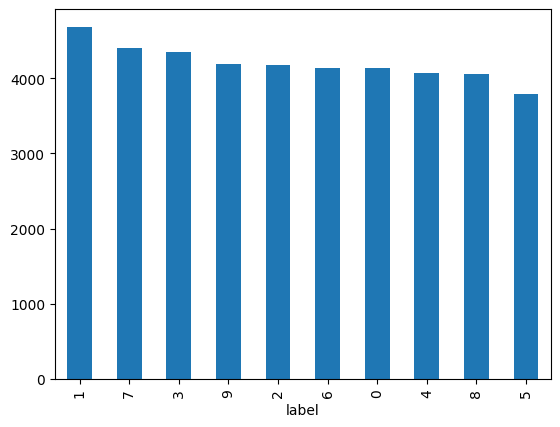

In [4]:
image_data['label'].value_counts().plot.bar()

### Split into X and y

In [5]:
X = image_data.loc[:,image_data.columns != 'label']
y = pd.get_dummies(image_data['label'])

### Turn vector into matrix
We reshape the vector into a 28 by 28 matrix (specified shape in the dataset) also indicating the channel dimension as 1 (since grayscale).

In [6]:
def create_images(X):
    X = X.to_numpy().reshape(-1, 28, 28, 1)
    return X

### Image Augmentation
Use keras image augmentation layers to add random noise to the dataset and prevent overfitting. For convinience I use an augmentation layer that takes a parameter magnitude to control the distortion of the image. 

Note: Normally you would use the RandAugment layer in keras but it only works for RGB images.

In [7]:
class RandomAugment(keras.Model): 
    def __init__(self, magnitude):
        super().__init__()
        
        self.layer = keras.Sequential([
            ### Look up these layers for more information
            keras.layers.RandomRotation(0.5 * magnitude**2, fill_mode = 'constant'),
            keras.layers.RandomTranslation(magnitude**3, magnitude, fill_mode = 'constant'),
            keras.layers.RandomContrast(magnitude),
            keras.layers.GaussianNoise(25 * magnitude)
        ])
        
    def call(self, x):
        return self.layer(x)

### View Images
Below is a utility function that we can use to see the images and determine good values for the magnitude that retain the images understandability while adding meaningful variety.

In [8]:
def show_images(X_image, magnitude = 0, nrows = 3, ncols = 3):
    
    plt.figure(figsize = (10, 10))
    idx = np.random.choice(X_image.shape[0], nrows * ncols)
    
    images = X_image[idx]
    if magnitude > 0:
        images = RandomAugment(magnitude)(images, training = True)
    
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')

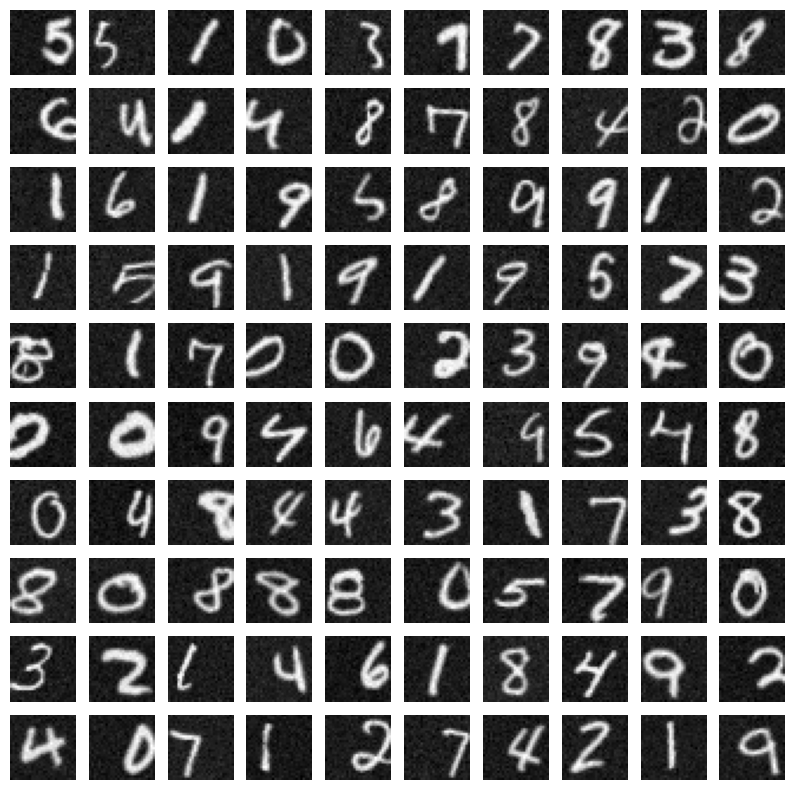

In [9]:
show_images(create_images(X), magnitude = 0.3, nrows = 10, ncols = 10)

## Create Model
You should mess around with potential designs that pop into your head as you go through this section.

### Introduction to Making CNNs

<img src="https://miro.medium.com/v2/resize:fit:1024/1*hs8Ud3X2LBzf5XMAFTmGGw.jpeg" alt="VGGNet — Convolutional Network for Classification and Detection | by Liang  Han Sheng | Analytics Vidhya | Medium"/>

- Continually **reduce spatial dimension** using pooling or strided convolutions.
- Continually **increase the number of channels**.
- Convert into a feature vector with global average pooling or flattening when the spatial dimension is reduced to the point where its no longer useful to analyze.
    - We will use global average pooling over flattening since its more cost efficient
    - To make up for the lack of features in the final vector, we can expand the channel dimension at the end more than usual using a 1x1 kernel size (since it only does feature proccessing and not spatial proccessing).
- Always use padding in convolutions so the convolution is done on edges.

In [10]:
def create_model():
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28, 1)),
        RandomAugment(magnitude = 0.15), # Different random augmentations every epoch, off during inference time
        keras.layers.Rescaling(1/255), # Rescale inputs from 0-255 to 0-1
        keras.layers.Conv2D(16, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(32, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(256, kernel_size = 1, activation = 'relu'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

### Visualize Model

In [11]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_augment_1 (RandomAu  (None, 28, 28, 1)         0         
 gment)                                                          
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         8448      
                                                      

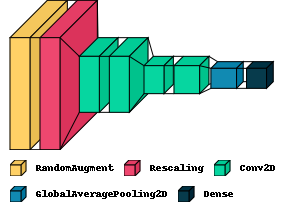

In [12]:
visualkeras.layered_view(model, legend = True)

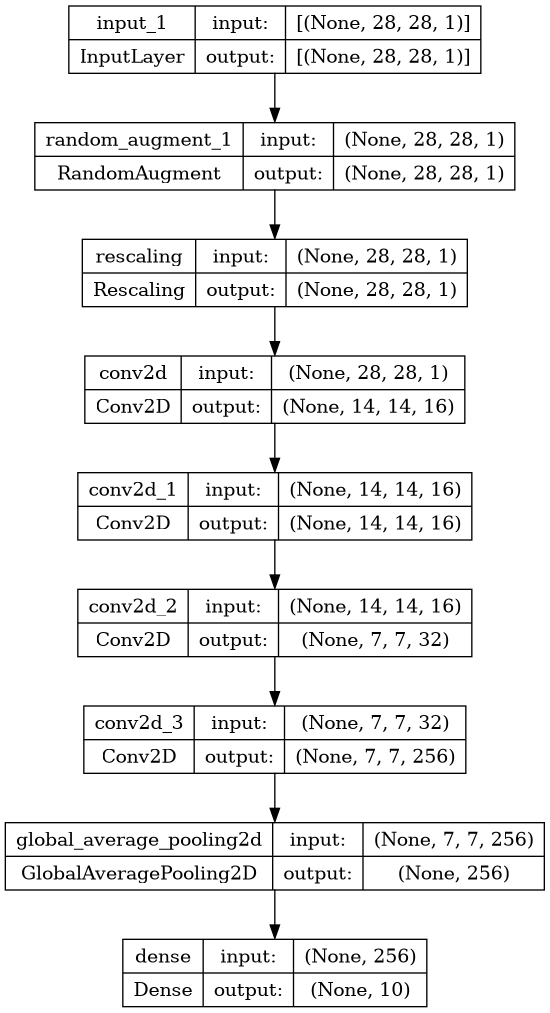

In [13]:
keras.utils.plot_model(model, show_shapes = True)

### Train Model

In [14]:
X_image = create_images(X)
X_train, X_val, y_train, y_val = train_test_split(X_image, y, test_size = 0.1)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20)

Epoch 1/20
1182/1182 [==============================] - 17s 13ms/step - loss: 1.2144 - accuracy: 0.5848 - val_loss: 0.5207 - val_accuracy: 0.8371
Epoch 2/20
1182/1182 [==============================] - 15s 12ms/step - loss: 0.4095 - accuracy: 0.8781 - val_loss: 0.3302 - val_accuracy: 0.8986
Epoch 3/20
1182/1182 [==============================] - 15s 12ms/step - loss: 0.3085 - accuracy: 0.9060 - val_loss: 0.2397 - val_accuracy: 0.9243
Epoch 4/20
1182/1182 [==============================] - 14s 12ms/step - loss: 0.2546 - accuracy: 0.9241 - val_loss: 0.2328 - val_accuracy: 0.9288
Epoch 5/20
1182/1182 [==============================] - 15s 13ms/step - loss: 0.2255 - accuracy: 0.9325 - val_loss: 0.2772 - val_accuracy: 0.9171
Epoch 6/20
1182/1182 [==============================] - 15s 12ms/step - loss: 0.1981 - accuracy: 0.9412 - val_loss: 0.1581 - val_accuracy: 0.9500
Epoch 7/20
1182/1182 [==============================] - 15s 13ms/step - loss: 0.1797 - accuracy: 0.9457 - val_loss: 0.1386 -

### Plot Training Curve

In [15]:
history_data = pd.DataFrame(history.history)
history_data

,loss,accuracy,val_loss,val_accuracy
0,1.214381,0.584841,0.520673,0.837143
1,0.409489,0.878148,0.330215,0.898571
2,0.308458,0.905952,0.239726,0.924286
3,0.254574,0.924074,0.232782,0.928810
4,0.225491,0.932460,0.277192,0.917143
5,0.198106,0.941164,0.158070,0.950000
6,0.179728,0.945688,0.138570,0.956190
7,0.165600,0.950159,0.114759,0.964762
8,0.152049,0.953228,0.141183,0.958095
9,0.137472,0.958413,0.116931,0.964048


<Axes: >

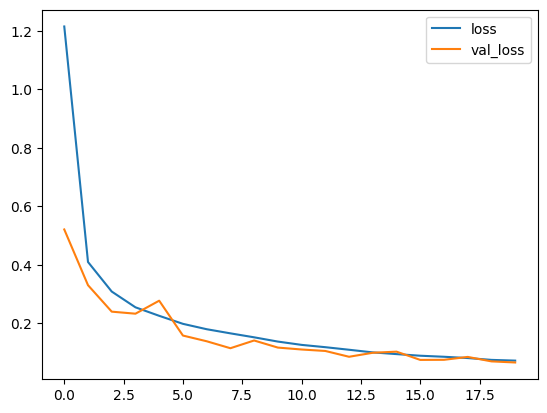

In [16]:
history_data[['loss', 'val_loss']].plot()

<Axes: >

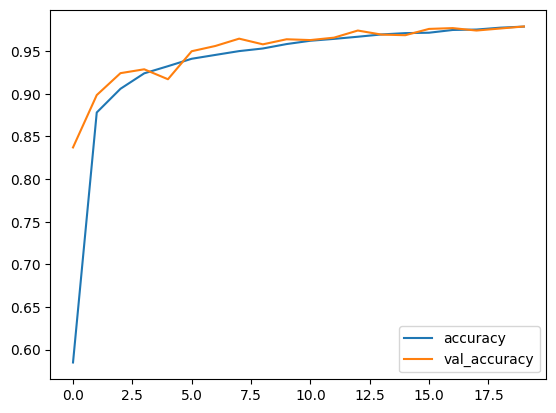

In [17]:
history_data[['accuracy', 'val_accuracy']].plot()

In [18]:
model.evaluate(X_val, y_val)

132/132 [==============================] - 1s 4ms/step - loss: 0.0660 - accuracy: 0.9790


[0.06604491919279099, 0.9790475964546204]

That's pretty good, but can we do better?

### Convolution Blocks

We can be more careful when designing the architecture by chunking up convolutions into blocks.
This is the basic block we will expand on later:
- The convoluiton
- Batchnorm
- Swish activation

There area also some small additions:
- More convolutions per stage (image size)
- AdamW with weight decay regularization

In [19]:
class Conv(keras.Model):
    def __init__(self, filters, kernel_size = 3, strides = 1, activation = 'swish'):
        super().__init__()
        
        self.conv =  keras.Sequential([
            keras.layers.Conv2D(
                filters = filters, 
                kernel_size = kernel_size,
                strides = strides,
                padding = 'same',
                use_bias = False),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activation)
        ])
        
    def call(self, x):
        return self.conv(x)

def create_model(weight_decay = 3e-4):
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28,1)),
        RandomAugment(0.15),
        keras.layers.Rescaling(scale = 1/255),
        Conv(32, strides = 2),
        Conv(32),
        Conv(32),
        Conv(64, strides = 2),
        Conv(64),
        Conv(64),
        Conv(256, kernel_size = 1),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = keras.optimizers.AdamW(weight_decay = weight_decay), 
        metrics = ['accuracy']
    )
    
    return model

In [20]:
model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_augment_2 (RandomAu  (None, 28, 28, 1)         0         
 gment)                                                          
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv (Conv)                 (None, 14, 14, 32)        416       
                                                                 
 conv_1 (Conv)               (None, 14, 14, 32)        9344      
                                                                 
 conv_2 (Conv)               (None, 14, 14, 32)        9344      
                                                                 
 conv_3 (Conv)               (None, 7, 7, 64)          18688     
                                                     

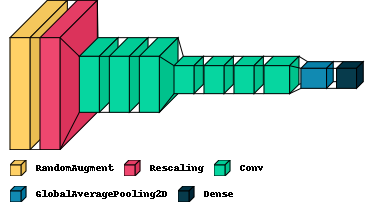

In [21]:
visualkeras.layered_view(model, legend = True)

We also add cosine annealing learning rate schedule with linear warmup

In [22]:
def cosine_annealing_schedule(initial_learning_rate = 1e-4,
                              learning_rate = 3e-3,
                              warmup_steps = 1,
                              decay_steps = 19):
    lr_schedule = keras.callbacks.LearningRateScheduler(
        keras.optimizers.schedules.CosineDecay(
            initial_learning_rate = initial_learning_rate,
            decay_steps = decay_steps,
            warmup_target = learning_rate,
            warmup_steps = warmup_steps
        )
    )
    
    return lr_schedule

In [23]:
lr_schedule = cosine_annealing_schedule()

history = model.fit(X_train, y_train, 
          validation_data = (X_val, y_val), 
          epochs = 20, 
          callbacks = [lr_schedule])

Epoch 1/20
1182/1182 [==============================] - 61s 48ms/step - loss: 0.5118 - accuracy: 0.8737 - val_loss: 0.1060 - val_accuracy: 0.9743 - lr: 1.0000e-04
Epoch 2/20
1182/1182 [==============================] - 57s 48ms/step - loss: 0.1157 - accuracy: 0.9651 - val_loss: 0.0483 - val_accuracy: 0.9869 - lr: 0.0030
Epoch 3/20
1182/1182 [==============================] - 57s 48ms/step - loss: 0.0620 - accuracy: 0.9810 - val_loss: 0.0755 - val_accuracy: 0.9764 - lr: 0.0030
Epoch 4/20
1182/1182 [==============================] - 57s 48ms/step - loss: 0.0478 - accuracy: 0.9854 - val_loss: 0.0577 - val_accuracy: 0.9824 - lr: 0.0029
Epoch 5/20
1182/1182 [==============================] - 58s 49ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.0478 - val_accuracy: 0.9862 - lr: 0.0028
Epoch 6/20
1182/1182 [==============================] - 58s 49ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0290 - val_accuracy: 0.9914 - lr: 0.0027
Epoch 7/20
1182/1182 [====================

In [24]:
history_data = pd.DataFrame(history.history)

<Axes: >

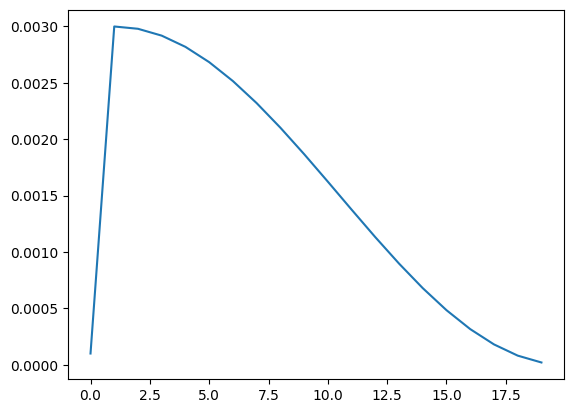

In [25]:
history_data['lr'].plot()

<Axes: >

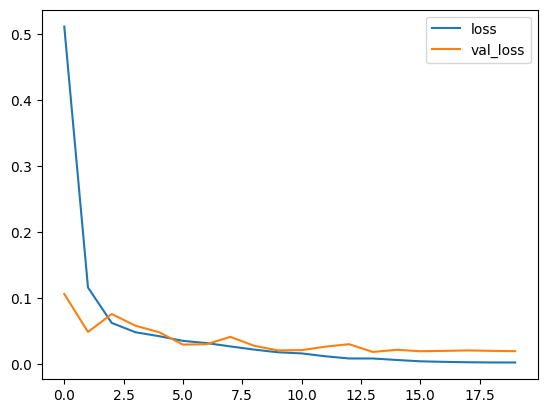

In [26]:
history_data[['loss', 'val_loss']].plot()

<Axes: >

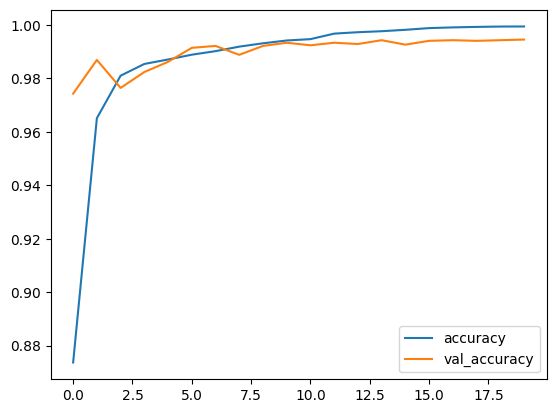

In [27]:
history_data[['accuracy', 'val_accuracy']].plot()

In [28]:
model.evaluate(X_val, y_val)

132/132 [==============================] - 2s 12ms/step - loss: 0.0191 - accuracy: 0.9945


[0.01911148987710476, 0.994523823261261]

A 99.5% validation accuracy, this is basically a perfect model, however it is overfitting a bit.

### EfficientNetV2 Blocks

For normal tasks we would simply use keras.applications.EfficientNetV2 and specify which size. However, that only works for very big datasets with much more complex and larges images.
Instead we can redisgn EfficientNetV2 using the FusedMBConv and MBConv blocks and then train using progressive learning.
<img src="https://user-images.githubusercontent.com/37800725/115514568-cfdc4900-a2b6-11eb-8adc-de6dc1f2c993.png" alt="About SE layer in Fused-MBConv · Issue #5 · d-li14/efficientnetv2.pytorch ·  GitHub"/>

In [29]:
class FusedMBConv(keras.Model):
    def __init__(self, filters, strides = 1, expansion_ratio = 4):
        super().__init__()
        self.skip = (strides == 1)
        
        self.expand = Conv(filters = expansion_ratio * filters, strides = strides)
        self.projection = Conv(filters, kernel_size = 1, activation = 'linear')
        
    def call(self, x):
        x_input = x
        
        x = self.expand(x)
        # EfficientNetV2 doesn't use SE in this block (despite whats depicted in the image)
        x = self.projection(x)
        
        if self.skip: x += x_input
            
        return x
    
class MBConv(keras.Model):
    def __init__(self, filters, strides = 1, expansion_ratio = 4, se_ratio = 0.25):
        super().__init__()
        self.skip = (strides == 1)
        
        self.expand = Conv(filters = expansion_ratio * filters, kernel_size = 1)
        
        self.depthwise = keras.layers.DepthwiseConv2D(
            kernel_size = 3, 
            strides = strides, 
            padding = 'same', 
            use_bias = False
        )
        self.bn = keras.layers.BatchNormalization()
        self.swish = keras.layers.Activation('swish')
        
        self.se = keras_cv.layers.SqueezeAndExcite2D(
            expansion_ratio * filters,
            bottleneck_filters = int(expansion_ratio * filters * se_ratio)
        )
        self.projection = Conv(filters, kernel_size = 1, activation = 'linear')
        
    def call(self, x):
        x_input = x
        
        x = self.expand(x)
        
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.swish(x)
        
        x = self.se(x)
        
        x = self.projection(x)
        
        if self.skip: x += x_input
            
        return x
    
def create_model(weight_decay = 3e-4, magnitude = 0.15, res = 48, dropout = 0.1):
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28, 1)),
        keras.layers.Resizing(res, res),
        RandomAugment(magnitude),
        keras.layers.Rescaling(1/255),
        Conv(filters = 16, strides = 2),
        FusedMBConv(16, expansion_ratio = 1),
        FusedMBConv(16),
        FusedMBConv(16),
        MBConv(filters = 32, strides = 2),
        MBConv(32),
        MBConv(32),
        MBConv(64, strides = 2),
        MBConv(filters = 64, expansion_ratio = 6),
        MBConv(filters = 64, expansion_ratio = 6),
        Conv(filters = 256, kernel_size = 1),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(dropout), # Add dropout regularization
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(
        loss = keras.losses.CategoricalCrossentropy(label_smoothing = 0.05), # Include label smoothing
        optimizer = keras.optimizers.AdamW(weight_decay = weight_decay), 
        metrics = ['accuracy']
    )
    
    return model

In [30]:
model = create_model()
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 48, 48, 1)         0         
                                                                 
 random_augment_3 (RandomAu  (None, 48, 48, 1)         0         
 gment)                                                          
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv_7 (Conv)               (None, 24, 24, 16)        208       
                                                                 
 fused_mb_conv (FusedMBConv  (None, 24, 24, 16)        2688      
 )                                                               
                                                                 
 fused_mb_conv_1 (FusedMBCo  (None, 24, 24, 16)      

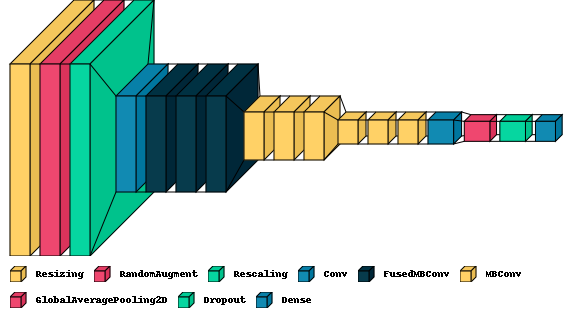

In [31]:
visualkeras.layered_view(model, legend = True)

### Progressive Learning
Higher Resolutions:
- Training on higher image resolutions adds more learnable complexity. 
- In this case it doesn't apply much since we basically already got a perfect model but in extremely complex real world datasets this is much needed.

Challenges:
- Training on higher image sizes is very slow, since our model can accept several image sizes we can train on a low image resolution where we learn the basics then move up to a high resolution where we learn more specific complexity.
- However, higher image resolutions need more regularization in order to prevent overfitting, while smaller image resolutions need less regularization in order to not underfit.

Solution:
- While progressively increasing the image size also progressively increase regularization.

In [32]:
class LinearSchedule:
    def __init__(self, initial, final, stages):
        self.initial = initial
        self.final = final
        self.timesteps = stages - 1
        
    def __call__(self, t):
        return self.initial * (1 - t / self.timesteps) + self.final * (t / self.timesteps)

def progressive_learning(X_train, X_val, y_train, y_val, 
                epochs_per_stage, 
                create_model = create_model,
                stages = 3,
                initial_res = 28, final_res = 48,
                initial_dropout = 0.1, final_dropout = 0.3,
                initial_magnitude = 0.1, final_magnitude = 0.3,
                model_path = '/kaggle/working/digit_model.h5'):

    dropout_schedule = LinearSchedule(initial_dropout, final_dropout, stages)
    res_schedule = LinearSchedule(initial_res, final_res, stages)
    magnitude_schedule = LinearSchedule(initial_magnitude, final_magnitude, stages)
    
    history = []
    
    for t in range(stages):
        dropout = dropout_schedule(t)
        res = int(res_schedule(t))
        magnitude = magnitude_schedule(t)
        print(f'{t + 1} / {stages} | dropout: {dropout}, res: {res}, magnitude: {magnitude}')
                
        model = create_model(res = res, dropout = dropout, magnitude = magnitude)
        
        lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: keras.optimizers.schedules.CosineDecay(
                initial_learning_rate = 1e-4,
                decay_steps = stages * epochs_per_stage - 1,
                warmup_target = 3e-3,
                warmup_steps = 1
            )(t * epochs_per_stage + epoch)
        )
        
        if t != 0:
            model.load_weights(model_path)
        
        stage_history = model.fit(X_train, y_train, 
                  batch_size = 32, epochs = epochs_per_stage,
                  validation_data = (X_val, y_val),
                  callbacks = [lr_schedule])
        history.append(pd.DataFrame(stage_history.history))
        
        model.save_weights(model_path)
        
    history_data = pd.concat(history).reset_index()
        
    return model, history_data

In [33]:
model, history_data = progressive_learning(
    X_train, X_val, y_train, y_val,
    epochs_per_stage = 10, stages = 3
)

1 / 3 | dropout: 0.1, res: 28, magnitude: 0.1
Epoch 1/10
1182/1182 [==============================] - 151s 117ms/step - loss: 0.7745 - accuracy: 0.8342 - val_loss: 0.4002 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 2/10
1182/1182 [==============================] - 145s 123ms/step - loss: 0.4034 - accuracy: 0.9651 - val_loss: 0.3666 - val_accuracy: 0.9795 - lr: 0.0030
Epoch 3/10
1182/1182 [==============================] - 142s 120ms/step - loss: 0.3472 - accuracy: 0.9813 - val_loss: 0.3588 - val_accuracy: 0.9769 - lr: 0.0030
Epoch 4/10
1182/1182 [==============================] - 136s 115ms/step - loss: 0.3404 - accuracy: 0.9835 - val_loss: 0.3577 - val_accuracy: 0.9762 - lr: 0.0030
Epoch 5/10
1182/1182 [==============================] - 138s 117ms/step - loss: 0.3328 - accuracy: 0.9860 - val_loss: 0.3241 - val_accuracy: 0.9895 - lr: 0.0029
Epoch 6/10
1182/1182 [==============================] - 134s 113ms/step - loss: 0.3265 - accuracy: 0.9873 - val_loss: 0.3485 - val_accuracy: 0.97

In [34]:
history_data

,index,loss,accuracy,val_loss,val_accuracy,lr
0,0,0.774481,0.834153,0.400220,0.969762,0.000100
1,1,0.403449,0.965079,0.366613,0.979524,0.003000
2,2,0.347150,0.981323,0.358845,0.976905,0.002991
3,3,0.340354,0.983466,0.357659,0.976190,0.002965
4,4,0.332812,0.986032,0.324098,0.989524,0.002921
5,5,0.326467,0.987275,0.348482,0.977857,0.002861
6,6,0.324271,0.987619,0.320153,0.987619,0.002785
7,7,0.319291,0.989101,0.311763,0.991905,0.002694
8,8,0.314556,0.991376,0.318784,0.988095,0.002589
9,9,0.310460,0.992540,0.305895,0.993333,0.002471


<Axes: >

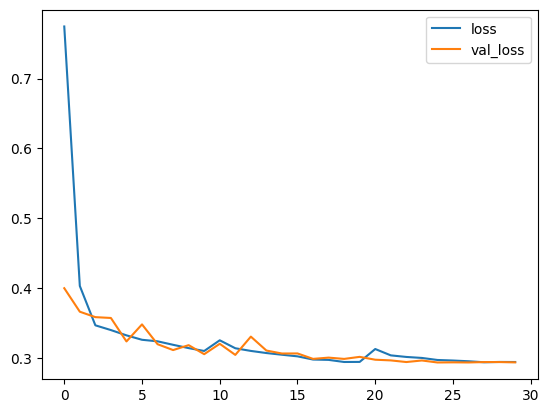

In [35]:
history_data[['loss', 'val_loss']].plot()

<Axes: >

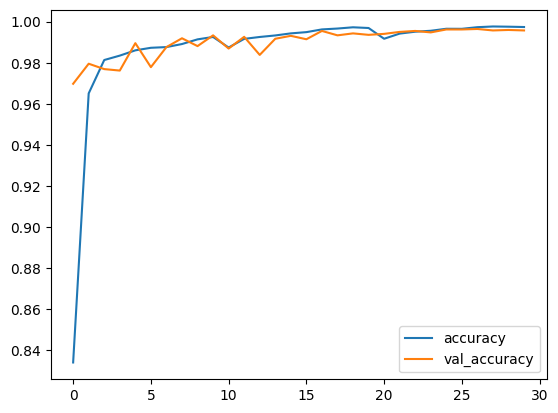

In [36]:
history_data[['accuracy', 'val_accuracy']].plot()

In [37]:
model = create_model()
model.load_weights('/kaggle/working/digit_model.h5')
model.evaluate(X_val, y_val)

132/132 [==============================] - 9s 55ms/step - loss: 0.2942 - accuracy: 0.9957


[0.2942012548446655, 0.9957143068313599]

Looks like the model is perfect, lets do a bit more analysis first though

### Error Analysis

In [38]:
def get_missed_indices(model, X, y):
    correct = (model.predict(X).argmax(axis = -1) == y.to_numpy().argmax(axis = -1))
    correct_data = pd.Series(correct)
    missed_indices = correct_data[~correct_data].index.to_numpy()
    
    return missed_indices

In [39]:
missed_indices = get_missed_indices(model, X_val, y_val)

132/132 [==============================] - 8s 57ms/step


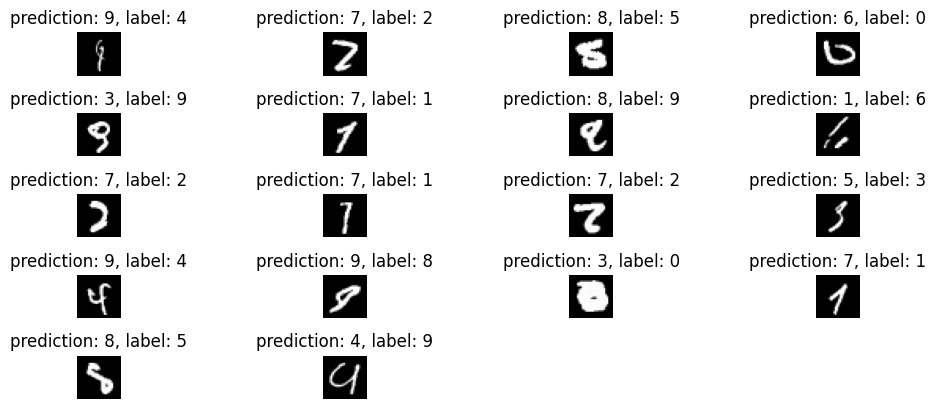

In [40]:
images = X_val[missed_indices]

plt.figure(figsize = (10,5))
for i in range(len(missed_indices)):
    plt.subplot(len(missed_indices)//3, 4, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.axis('off')
    pred = model.predict(np.expand_dims(images[i], 0), verbose = 0).argmax()
    plt.title(f'prediction: {pred}, label: {y_val.to_numpy()[missed_indices[i]].argmax()}')
plt.tight_layout()

It looks like all of the examples the model missed are all unfair, preforming as well as a human would.